In [209]:
#Importing needed modules.
from pandas import read_csv
from numpy import mean
from matplotlib.pyplot import plot , show , xlabel , ylabel , title , figure
from tensorflow.data import Dataset
from tensorflow.keras import layers ,  models
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import mean_squared_error , mean_absolute_error 
from tensorflow.keras.callbacks import Callback

In [210]:
#Reading csv file and getting 10 sample of that randomly .
path = "D:\\datasets\\USD_EGP Historical\\USD_EGP Historical Data1.csv"
file = read_csv(path)
df = file.copy()
df.sample(10)

,Date,Price,Open,High,Low,Change %
356,2022-02-22,15.6700,15.7000,15.7500,15.6900,0.00%
6700,2003-07-28,6.1550,6.1250,6.1850,6.0350,0.32%
3686,2012-01-06,6.0362,6.0362,6.0362,6.0362,0.00%
690,2020-10-27,15.6700,15.7100,15.7425,15.6800,0.13%
7601,2000-02-09,3.4500,3.4390,3.4620,3.4360,-0.03%
9405,1993-03-05,3.3450,3.3450,3.3450,3.3450,0.00%
6799,2003-03-11,5.7150,5.6650,5.7250,5.5950,0.53%
4221,2010-07-20,5.6980,5.6970,5.7009,5.6960,0.00%
7965,1998-09-16,3.4040,3.4074,3.4279,3.3969,0.01%
1239,2018-12-06,17.9100,17.9300,18.0300,17.8300,-0.14%


In [211]:
#Getting information from data frame .
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9870 entries, 0 to 9869
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      9870 non-null   object 
 1   Price     9870 non-null   float64
 2   Open      9870 non-null   float64
 3   High      9870 non-null   float64
 4   Low       9870 non-null   float64
 5   Change %  9870 non-null   object 
dtypes: float64(4), object(2)
memory usage: 462.8+ KB


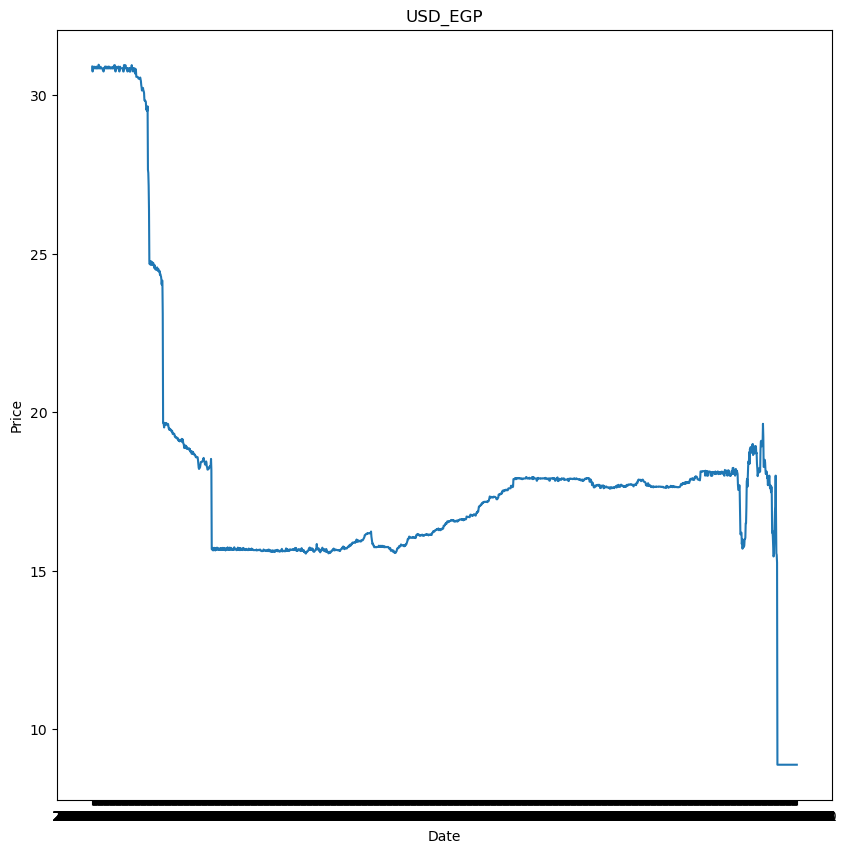

In [212]:
#Plotting part of dataset by a function.
def Plot(x,y,x_name,y_name,title_name,idx=None,f_size=(10,10))->None :
    '''function docstring'''
    figure(figsize=f_size)
    plot(x.to_list()[:idx],y.to_list()[:idx])
    xlabel(x_name)
    ylabel(y_name)
    title(title_name)
    show()
    
Plot(df.Date,df.Price,'Date','Price','USD_EGP',idx=2000)

In [213]:
#Separating prices to train and test sets by a function.
def Split(Set,train_size)->'ndarray' :
    '''function'''
    idx = (train_size*len(Set))//100
    return Set[:idx] , Set[idx:] , idx

xtr , xts , Index = Split(df.Price.to_numpy(),
                 int(input('Enter train size :')))

Enter train size :80


In [214]:
print(f'There are {len(xtr)} samples for training and {len(xts)} for testing.')

There are 7896 samples for training and 1974 for testing.


In [215]:
#Making datasets for feeding our network.
def Make_dataset(data,window_size=32,shift=1,shuffle_size=2000,p=1,key=None)->None :
    '''function docstring'''
    if key == 'train' :
        train = Dataset.from_tensor_slices(data)
        train = train.window(window_size,shift=shift,drop_remainder=True)
        train = train.flat_map(lambda x : x.batch(window_size))
        train = train.shuffle(shuffle_size).map(lambda x : (x[:-1],x[-1]))
        train = train.batch(window_size+2).prefetch(1)
        return train
    elif key == 'test' :
        test = Dataset.from_tensor_slices(data)
        test = test.window(window_size,shift=shift,drop_remainder=True)
        test = test.flat_map(lambda x : x.batch(window_size))
        test = test.batch(window_size+2).prefetch(p)
        return test
    else :
        print('Please enter a valid key.')

In [216]:
train_ds = Make_dataset(xtr,
                        window_size=32,
                        shift=1,
                        shuffle_size=1000,
                        p=1,
                        key='train')
test_ds = Make_dataset(df.Price.to_numpy(),
                       window_size=32,
                       shift=1,
                       p=1,
                       key='test')

In [217]:
#Defining a model by a function.
def Create_model()->None :
    '''function docstring'''
    model = models.Sequential([layers.Dense(20,activation='relu',input_shape=[None,1]),
                               layers.Dense(20,activation='relu'),
                              layers.Dense(1)])
    model.compile(optimizer=RMSprop(),
                 loss=Huber(),
                 metrics=['mae'])
    return model

In [218]:
#Creating a class in order to stop model at inputted mae.
class callbks(Callback):
    def on_epoch_end(self,epoch,log=dict()):
        if (log.get('mae')<2.5) :
            print('\nmae is low , so cancelling training!')
            self.model.stop_training = True

In [219]:
#Datas train.
call = callbks()
history = Create_model().fit(train_ds,epochs=20,callbacks=call)

Epoch 1/20
232/232 [==============================] - 1s 3ms/step - loss: 4.1963 - mae: 4.5756
Epoch 2/20
227/232 [============================>.] - ETA: 0s - loss: 1.8390 - mae: 2.1882
mae is low , so cancelling training!
232/232 [==============================] - 1s 4ms/step - loss: 1.8172 - mae: 2.1675


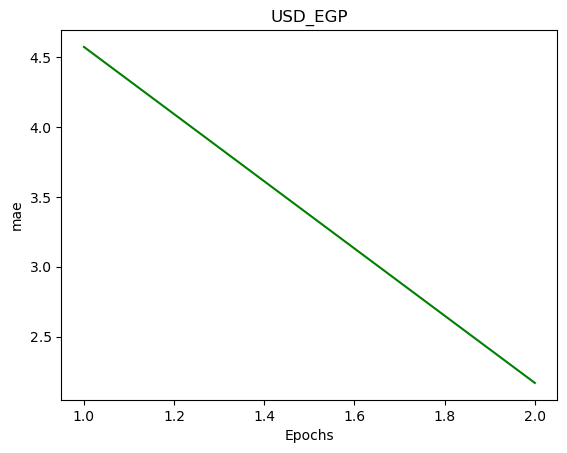

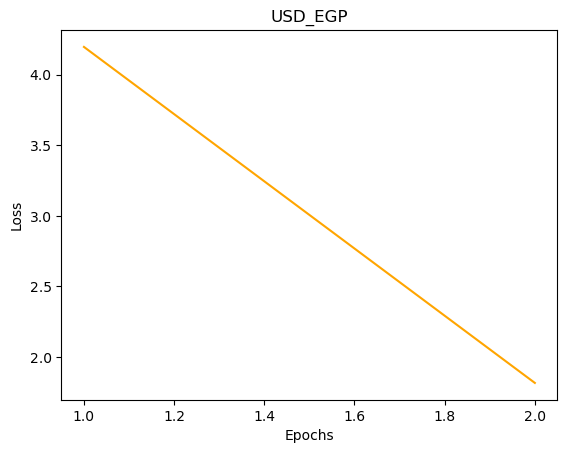

In [224]:
#Visualize models performance.
epoch = range(1,len(history.epoch)+1)
results = history.history
plot(epoch,results['mae'],'green')
xlabel('Epochs')
ylabel('mae')
title('USD_EGP')
show()
plot(epoch,results['loss'],'orange')
xlabel('Epochs')
ylabel('Loss')
title('USD_EGP')
show()

In [221]:
#Predicting test samples.
preds = Create_model().predict(test_ds)
true_preds = preds[Index-32:-1]
mse = mean(mean_squared_error(xts,true_preds).numpy()[0])
mae = mean(mean_absolute_error(xts,true_preds).numpy()[0])
message = 'mse : %2.f , mae : %2.f'%(mse,mae)
print(message)

290/290 [==============================] - 2s 6ms/step
mse :  8 , mae :  3


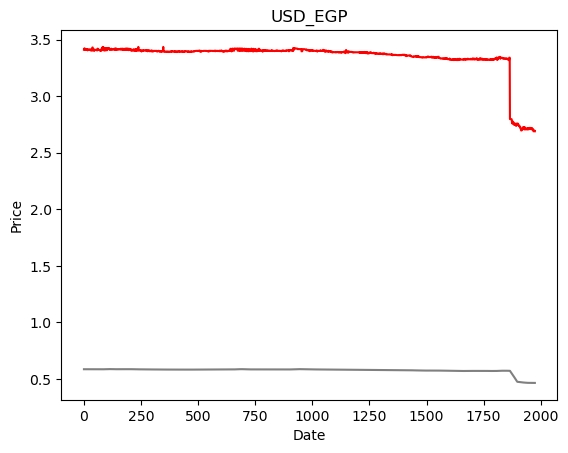

In [223]:
#Visualize prediction performance.
temp = []
res = []
for i in true_preds :
    for j in i :
        for k in j :
            temp.append(k)
    val = mean(temp)
    res.append(val)
    temp = []
plot(range(1,len(xts)+1),xts,'red')
plot(range(1,len(res)+1),res,'gray')
xlabel('Date')
ylabel('Price')
title('USD_EGP')
show()